## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
!rm -rf ~/.cache/huggingface/datasets


In [5]:
from datasets import load_dataset
dataset = load_dataset("emotion")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [8]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [10]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [13]:
tokenizer.fit_on_texts(tweets)

# Convert first tweet to sequence
tokenizer.texts_to_sequences([tweets[0]])

# View original tweet
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

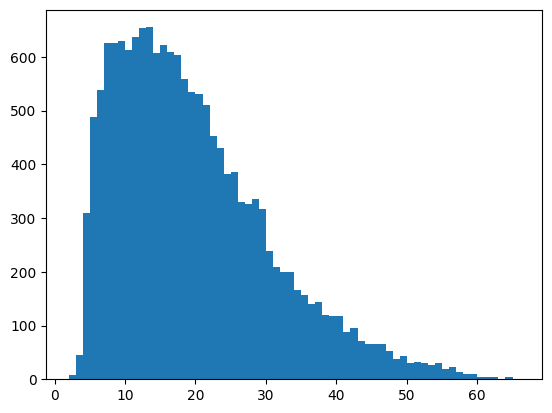

In [14]:
import matplotlib.pyplot as plt

lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()


In [15]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences


In [16]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(
        sequences,
        truncating='post',
        padding='post',
        maxlen=maxlen
    )
    return padded


In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)


In [18]:
padded_train_seq[0]


array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


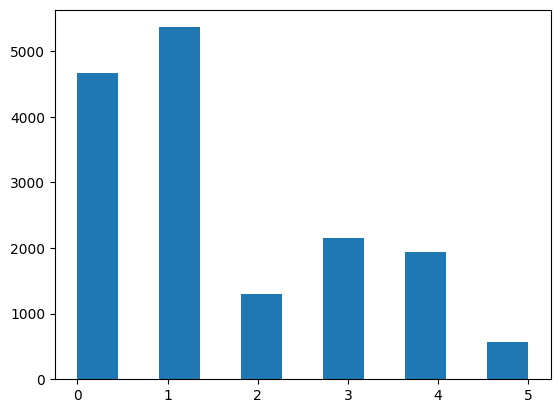

In [20]:
plt.hist(labels, bins=11)
plt.show()

In [21]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())


In [22]:
class_to_index


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [23]:
index_to_class


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [24]:
import numpy as np

names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])


In [25]:
train_labels = names_to_ids(labels)
print(train_labels[0])


0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [29]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(maxlen,)),
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(20, return_sequences=True)
    ),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(20)
    ),
    tf.keras.layers.Dense(6, activation='softmax')
])



In [30]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [31]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [32]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)


In [33]:
h = model.fit(
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2
        )
    ]
)


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.3476 - loss: 1.5615 - val_accuracy: 0.6625 - val_loss: 0.9153
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7659 - loss: 0.6582 - val_accuracy: 0.8180 - val_loss: 0.5279
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8898 - loss: 0.3430 - val_accuracy: 0.8610 - val_loss: 0.4399
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9289 - loss: 0.2185 - val_accuracy: 0.8620 - val_loss: 0.4370
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9455 - loss: 0.1682 - val_accuracy: 0.8635 - val_loss: 0.4575
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9544 - loss: 0.1458 - val_accuracy: 0.8695 - val_loss: 0.4302
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9610 - loss: 0.1176 - val_accuracy: 0.8780 - val_loss: 0.4327
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9649 - loss: 0.1065 - val_acc

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

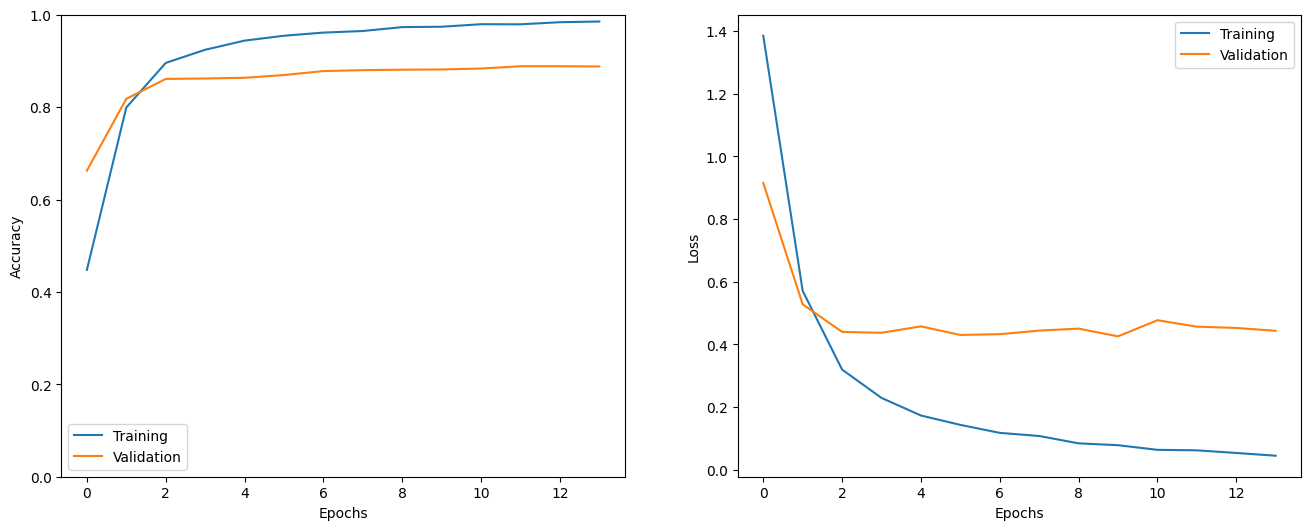

In [34]:
show_history(h)

In [35]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)


In [36]:
_ = model.evaluate(test_seq, test_labels)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8846 - loss: 0.4573


In [37]:
import random
import numpy as np

i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)


Sentence: i feel like i finally want to write about one of my vain hobbies makeup
Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicted Emotion: 0


In [38]:
import numpy as np

pred_probs = model.predict(test_seq)
preds = np.argmax(pred_probs, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


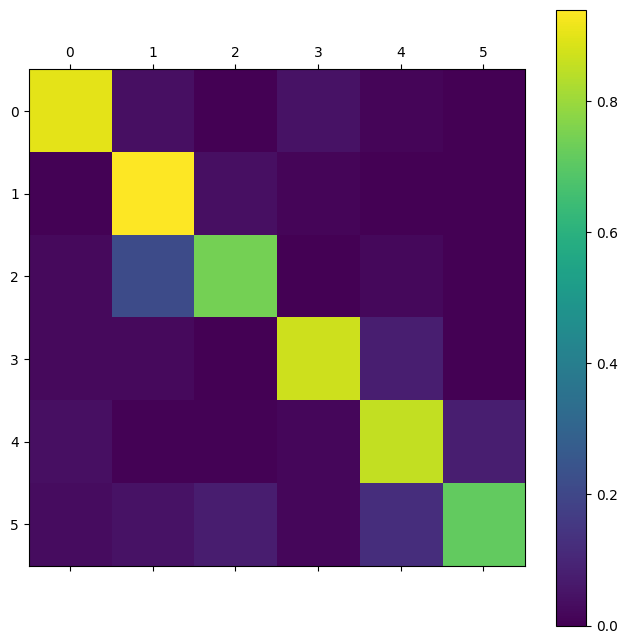

In [39]:
show_confusion_matrix(test_labels, preds, list(classes))
